# Converting MLDS Responses to MOS values using TID2013

This script loads the database of the MLDS curves described in
**"Response to Affine Transforms of Image Distance Metrics and Humans"**.

Then we select the data that is common with the target database.
In this example we use TID2013, and the common data is the gaussian noise for some particular noise levels. From this selected data we compute the coefficientes of a linear regression.

Then we apply the linear regression to convert all RAID data to MOS.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install datasets
from datasets import load_dataset

### Load MLDS Responses

In [12]:

url = 'https://raw.githubusercontent.com/paudauo/BBDD_Affine_Transformations/refs/heads/main/responses.csv'
df = pd.read_csv(url,header=0, on_bad_lines='skip')
print(df.head(5))

    Reference                Distorted  Curve_Value    Sigmas  Response  \
0  img_01.png  rot_img_01_level_01.png     0.000000  0.220711  0.000000   
1  img_01.png  rot_img_01_level_02.png     0.113924  0.220711  0.516166   
2  img_01.png  rot_img_01_level_03.png     0.185471  0.220711  0.840336   
3  img_01.png  rot_img_01_level_04.png     0.346350  0.220711  1.569247   
4  img_01.png  rot_img_01_level_05.png     0.417098  0.220711  1.889793   

   Estimated_MOS  
0       5.590099  
1       5.275201  
2       5.077435  
3       4.632746  
4       4.437191  


In [13]:
#Choose only images that are common in both databases
filter = df['Distorted'].str.contains(r'^gn_.*_level_(02|03|05|10)\.png$', regex=True)
df_filtered = df[filter]

MLDS_filtered = df_filtered.Response.to_numpy()

<ipython-input-13-ded93825b32c>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df['Distorted'].str.contains(r'^gn_.*_level_(02|03|05|10)\.png$', regex=True)


### Load MOS of TID2013

In [14]:
tid13 = load_dataset("Jorgvt/TID2013", trust_remote_code=True)
tid13 = tid13["train"]
mos = tid13["mos"]

In [25]:
# Choose only images that are common in both databases
group_size = 120
mos_gn = []
for i in range(0, len(mos), group_size):
    mos_gn.append(mos[i:i+5])
mos_gn = np.concatenate(mos_gn)
mos_gn=mos_gn[:-5]

ind = list(range(0, 120, 5))
mos_filtered = np.delete(mos_gn, ind, axis=0)

Text(0, 0.5, 'Response')

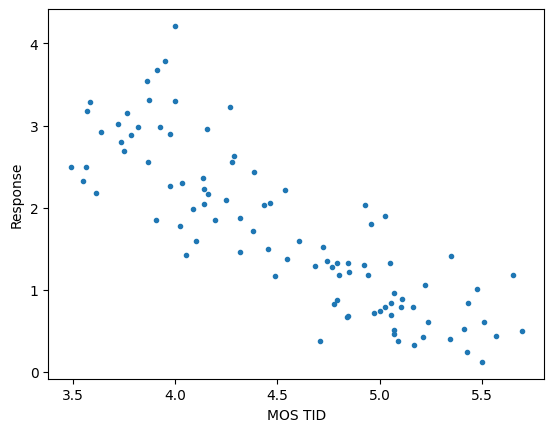

In [26]:
plt.plot(mos_filtered,MLDS_filtered,'.')
plt.xlabel('MOS TID')
plt.ylabel('Response')

### Compute regression cofficients

In [ ]:
# Mean, standard deviation and cross-covariance
mu_TID = np.mean(mos_filtered)

mu_MLDS= np.mean(MLDS_filtered)
sigma_MLDS = np.std(MLDS_filtered)

cov_TID_MLDS = np.cov(mos_filtered,MLDS_filtered)[0,1]

#Coefficients
a = cov_TID_MLDS / sigma_MLDS**2
b = mu_TID - a * mu_MLDS

Text(0.5, 1.0, 'Correlation: 0.84')

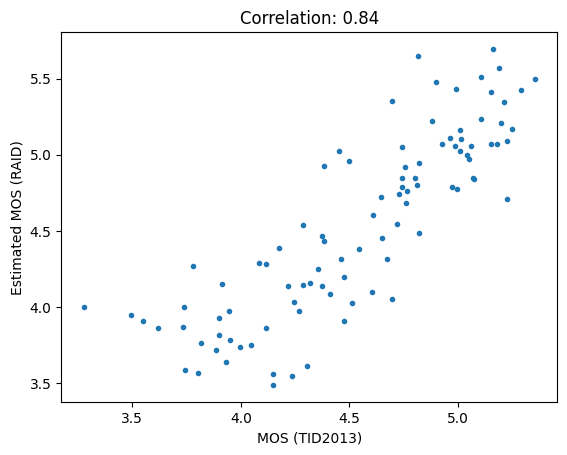

In [28]:
# Transforming all the RAID MLDS values using the fitted Transformation
est_MOS_filtered = a * MLDS_filtered + b

#
plt.plot(est_MOS_filtered,mos_filtered,'.')
plt.xlabel('MOS (TID2013)')
plt.ylabel('Estimated MOS (RAID)')

plt.title('Correlation: ' + str(np.round(np.corrcoef(est_MOS_filtered,mos_filtered)[0,1],2)))

### Transform all the RAID data

In [29]:
# Transforming all the MLDS values using the fitted Transformation
est_MOS = a * df.Response + b


Text(0, 0.5, 'Estimated MOS')

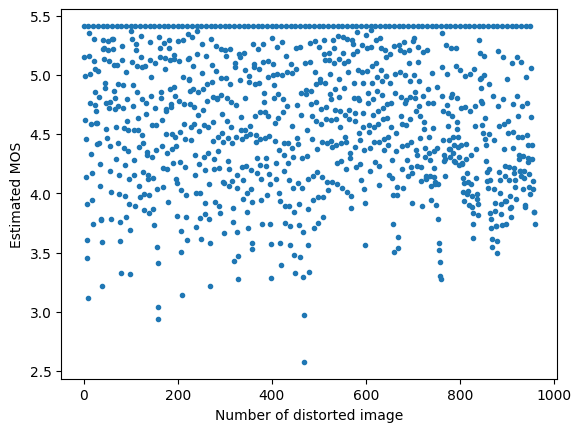

In [30]:
plt.plot(est_MOS,'.')
plt.xlabel('Number of distorted image')
plt.ylabel('Estimated MOS')